# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 1 - Smoothers and Generalized Additive Models



**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner


<hr style="height:2pt">

### Homework 1 is due February 6th

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder

# Seaborn visualization library
import seaborn as sns


<hr style="height:2pt">

### Problem 1 - Modeling Seasonality of Airbnb Prices
In this problem, the task is to build a regression model to predict the price of an Airbnb rental for a given date. The data are provided in `calendar_train.csv` and `calendar_test.csv`, which contain availability and price data for a sample of Airbnb units in the Boston area from 2017 to 2018, about 4 observations per day in each set.

Start by loading the data using pandas.  
*Hint*: You likely want to have pandas parse the `date` column as a datetime object via the `parse_dates` argument of `pd.read_csv`

In [3]:
airp = pd.read_csv("./data/calendar_train.csv")
airp['date'] = pd.to_datetime(airp['date'])
airp = airp.dropna().reset_index()
airp.head(10)

,index,listing_id,date,available,price
0,123,20872145,2018-04-02,t,62.0
1,124,20872145,2018-04-01,t,59.0
2,125,20872145,2018-03-31,t,75.0
3,126,20872145,2018-03-30,t,71.0
4,127,20872145,2018-03-28,t,51.0
5,128,20872145,2018-03-24,t,46.0
6,129,20872145,2018-03-20,t,45.0
7,130,20872145,2018-03-19,t,45.0
8,131,20872145,2018-03-18,t,45.0
9,132,20872145,2018-03-17,t,47.0


In [4]:
airp_test = pd.read_csv("./data/calendar_test.csv")
airp_test['date'] = pd.to_datetime(airp_test['date'])
airp_test = airp_test.dropna().reset_index()
airp_test.head(10)

,index,listing_id,date,available,price
0,0,21205442,2018-09-28,t,138.0
1,1,5166870,2018-08-11,t,210.0
2,12,19455818,2018-04-13,t,869.0
3,14,20351854,2017-12-23,t,239.0
4,17,20622324,2018-02-09,t,259.0
5,26,19309434,2018-06-30,t,227.0
6,27,14253485,2018-05-25,t,375.0
7,28,8283955,2018-08-13,t,240.0
8,29,17701434,2018-01-18,t,125.0
9,32,14820482,2018-02-01,t,382.0


In [5]:
airp.dtypes

index                  int64
listing_id             int64
date          datetime64[ns]
available             object
price                float64
dtype: object

In [6]:
airp_test.dtypes

index                  int64
listing_id             int64
date          datetime64[ns]
available             object
price                float64
dtype: object

In [7]:
airp.describe()

,index,listing_id,price
count,309288.000000,3.092880e+05,309288.000000
mean,353165.656569,1.185732e+07,238.780612
std,212208.826696,6.716094e+06,188.527983
min,123.000000,3.781000e+03,15.000000
25%,175464.750000,5.940866e+06,115.000000
50%,345617.500000,1.302981e+07,190.000000
75%,530085.250000,1.815527e+07,299.000000
max,733766.000000,2.122836e+07,5993.000000


In [8]:
for column in airp.columns:
    uniques = sorted(airp[column].unique())
    empty = len(airp[airp[column] == '']) 
    print('{0:25s} {1:5d} {2:5d}\t'.format(column, len(uniques), empty) , uniques[:5])

index                     309288     0	 [123, 124, 125, 126, 127]
listing_id                 2254     0	 [3781, 5506, 6695, 6976, 8792]
date                        365     0	 [numpy.datetime64('2017-10-06T00:00:00.000000000'), numpy.datetime64('2017-10-07T00:00:00.000000000'), numpy.datetime64('2017-10-08T00:00:00.000000000'), numpy.datetime64('2017-10-09T00:00:00.000000000'), numpy.datetime64('2017-10-10T00:00:00.000000000')]
available                     1     0	 ['t']
price                       902     0	 [15.0, 16.0, 17.0, 18.0, 19.0]


/anaconda3/envs/cs109b/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:252: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


### Exploratory Analysis

Visualize the average price by month and day of the week (i.e., Monday, Tuesday, etc.) for the training set. Point out any trends you notice and explain whether or not they make sense.

In [9]:
#your code here
airp['month'] = airp['date'].dt.month
airp['day'] = airp['date'].dt.dayofweek
airp.head()

,index,listing_id,date,available,price,month,day
0,123,20872145,2018-04-02,t,62.0,4,0
1,124,20872145,2018-04-01,t,59.0,4,6
2,125,20872145,2018-03-31,t,75.0,3,5
3,126,20872145,2018-03-30,t,71.0,3,4
4,127,20872145,2018-03-28,t,51.0,3,2


In [10]:
month_price = airp.groupby(['month']).mean()['price'].reset_index()
# month_price.head(12)

Text(0, 0.5, 'Average Price')

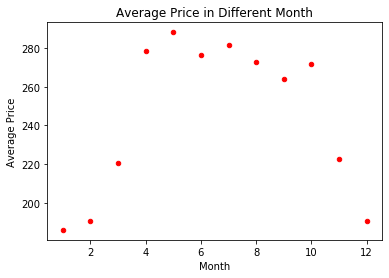

In [11]:
ax1 = month_price.plot.scatter(x='month',y='price',c='Red',title="Average Price in Different Month")
ax1.set_xlabel("Month")
ax1.set_ylabel("Average Price")

In [12]:
day_price = airp.groupby(['day']).mean()['price'].reset_index()

Turn the day of the week into number, where Monday=0 and Sunday=6.

Text(0, 0.5, 'Average Price')

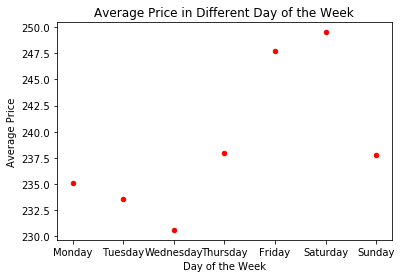

In [13]:
ax1 = day_price.plot.scatter(x='day',y='price',c='Red',title="Average Price in Different Day of the Week")
plt.xticks([0,1,2,3,4,5,6],['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
ax1.set_xlabel("Day of the Week")
ax1.set_ylabel("Average Price")

The trend I obersved in the first figure(price vs month) is that the price is higher in the summer time(from April to October) and lower in the winter time(November to March). More percise, the prices in November and March are between the summer average price and winter average price, which can be ragarded as transition time. The trend makes sense bacause the weather is warm and nice in summer, when people like to travel to Boston, and the weather is cold and unpleasant in the winter time, when most travelers wouldn't prefer to travel.

The trend I observed from the second figure (price vs day of the week) is that the price is higher in the weekend (Friday and Saturday) and lower in the weekdays (Sunday to Thursday). The trend makes sense, because for short term travelers, they tend to stay starting from Friday, which is the beginning of the weekend and leave on Sunday, which is the end of the weekend. As for the weekdays, there will be fewer travellers so that the prices would be lower. Similiarly, the prices on Thursday and Sunday are in between, which can be regarded as transition time. 

### Explore different regression models

Fit a regression model that uses the date as a predictor and predicts the price of an Airbnb rental on that date. In this section, you should ignore all other predictors besides the date. Fit the following models on the training set, and compare the $R^2$ of the fitted models on the test set. Include plots of the fitted models for each method.

*Hint*: You may want to convert the `date` column into a numerical variable by taking the difference in days between each date and the earliest date in the column.

1. Fit simple polynomial models of degree 2, 3, 5, and 8 to the training data. Provide train and test R^2 scores and provide plot(s) of a) the daily averages and b) each model's predictions.

2. You should see that the degree 8 polynomial's predictions are awful- either nonsensically near zero [or far too large] at many input values. This isn't just simple overfitting. What is going wrong in this model, and how might it be addressed?

3. Fit a Smoothing spline model in `pygam` with the smoothness parameter chosen by cross-validation on the training set. Provide the train and test scores of the best-performing model, and plot its predictions. Also plot the predictions of models with more and less smoothing. When plotting the smooths, show a scatterplot of the daily averages on the same axes, for context.

4. Of the models, which performs the best? What is the effect of the tuning parameters (degree and smoothness penalty)?

### 1. Polynomials

#### degree 2

In [14]:
min_date = min(airp['date'].min(), airp_test['date'].min())
airp['datedif'] = (airp['date'] - min_date).dt.days
airp_test['datedif'] = (airp_test['date'] - min_date).dt.days
airp_ave = airp.groupby(['datedif']).mean()['price'].reset_index()
airp_ave_test = airp_test.groupby(['datedif']).mean()['price'].reset_index()

In [15]:
predict_df = airp_ave[['datedif']]
predict_df_test = airp_ave_test[['datedif']]

In [16]:
fit_lm = sm.ols(formula="price ~ datedif + np.power(datedif,2)",data=airp_ave).fit()
prediction_output = fit_lm.get_prediction(predict_df).summary_frame()
prediction_output.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,230.871089,6.515105,218.058882,243.683297,147.836887,313.905292
1,230.782901,6.443906,218.110710,243.455091,147.770188,313.795614
2,230.696199,6.373301,218.162855,243.229542,147.704568,313.687829
3,230.610983,6.303295,218.215309,243.006656,147.640031,313.581934
4,230.527253,6.233890,218.268066,242.786439,147.576582,313.477923


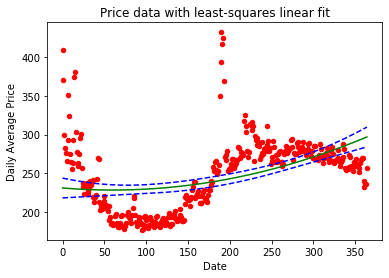

In [17]:
ax1 = airp_ave.plot.scatter(x='datedif',y='price',c='Red',title="Price data with least-squares linear fit")
ax1.set_xlabel("Date")
ax1.set_ylabel("Daily Average Price")

ax1.plot(predict_df['datedif'], prediction_output['mean'],color="green")
ax1.plot(predict_df['datedif'], prediction_output['mean_ci_lower'], color="blue",linestyle="dashed")
ax1.plot(predict_df['datedif'], prediction_output['mean_ci_upper'], color="blue",linestyle="dashed");

In [18]:
r2_train = r2_score(airp_ave['price'], prediction_output['mean'])
r2_test = r2_score(airp_ave_test['price'], fit_lm.get_prediction(predict_df_test).summary_frame()['mean'])
print('training r2 score:',r2_train,', test r2 score:', r2_test)

training r2 score: 0.19584841843111234 , test r2 score: 0.20031669853628298


#### degree 3

In [19]:
fit_lm = sm.ols(formula="price ~ datedif + np.power(datedif,2) + np.power(datedif,3)",data=airp_ave).fit()
prediction_output = fit_lm.get_prediction(predict_df).summary_frame()
prediction_output.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,311.049572,5.808620,299.626588,322.472555,254.757943,367.341200
1,308.318136,5.690179,297.128075,319.508198,252.073312,364.562961
2,305.624596,5.573891,294.663221,316.585970,249.424822,361.824370
3,302.968749,5.459761,292.231816,313.705681,246.812319,359.125178
4,300.350394,5.347795,289.833649,310.867138,244.235647,356.465140


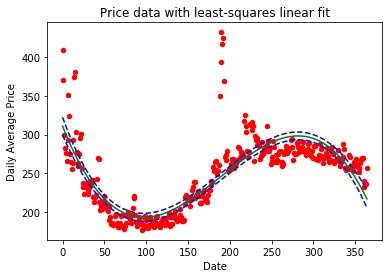

In [20]:
ax1 = airp_ave.plot.scatter(x='datedif',y='price',c='Red',title="Price data with least-squares linear fit")
ax1.set_xlabel("Date")
ax1.set_ylabel("Daily Average Price")

ax1.plot(predict_df['datedif'], prediction_output['mean'],color="green")
ax1.plot(predict_df['datedif'], prediction_output['mean_ci_lower'], color="blue",linestyle="dashed")
ax1.plot(predict_df['datedif'], prediction_output['mean_ci_upper'], color="blue",linestyle="dashed");

In [21]:
r2_train = r2_score(airp_ave['price'], prediction_output['mean'])
r2_test = r2_score(airp_ave_test['price'], fit_lm.get_prediction(predict_df_test).summary_frame()['mean'])
print('training r2 score:',r2_train,', test r2 score:', r2_test)

training r2 score: 0.6380031312876848 , test r2 score: 0.6139438232999757


#### degree 5

In [22]:
fit_lm = sm.ols(formula="price ~ datedif + np.power(datedif,2) + np.power(datedif,3)+ np.power(datedif,4)+ np.power(datedif,5)",data=airp_ave).fit()
prediction_output = fit_lm.get_prediction(predict_df).summary_frame()
prediction_output.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,336.232997,7.622590,321.242459,351.223536,285.104425,387.361570
1,332.429559,7.265070,318.142116,346.717001,281.502693,383.356424
2,328.677711,6.924294,315.060437,342.294986,277.934783,379.420640
3,324.977410,6.600155,311.997585,337.957235,274.401818,375.553002
4,321.328602,6.292556,308.953701,333.703504,270.904870,371.752335


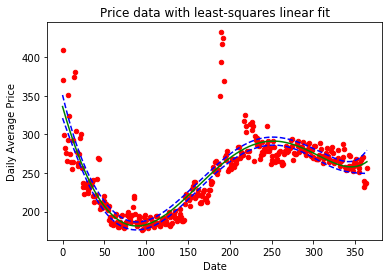

In [23]:
ax1 = airp_ave.plot.scatter(x='datedif',y='price',c='Red',title="Price data with least-squares linear fit")
ax1.set_xlabel("Date")
ax1.set_ylabel("Daily Average Price")

ax1.plot(predict_df['datedif'], prediction_output['mean'],color="green")
ax1.plot(predict_df['datedif'], prediction_output['mean_ci_lower'], color="blue",linestyle="dashed")
ax1.plot(predict_df['datedif'], prediction_output['mean_ci_upper'], color="blue",linestyle="dashed");

In [24]:
r2_train = r2_score(airp_ave['price'], prediction_output['mean'])
r2_test = r2_score(airp_ave_test['price'], fit_lm.get_prediction(predict_df_test).summary_frame()['mean'])
print('training r2 score:',r2_train,', test r2 score:', r2_test)

training r2 score: 0.7168986371398361 , test r2 score: 0.6850165200653858


### 2. Degree 8 oddity

In [25]:
fit_lm = sm.ols(formula="price ~ datedif + np.power(datedif,2) + np.power(datedif,3)+ np.power(datedif,4)+ np.power(datedif,5)+ np.power(datedif,6)+ np.power(datedif,7)+ np.power(datedif,8)",data=airp_ave).fit()
prediction_output = fit_lm.get_prediction(predict_df).summary_frame()
prediction_output.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,6.044160e-09,5.954252e-10,4.873201e-09,7.215120e-09,-204.883713,204.883713
1,1.019359e-03,1.001419e-04,8.224206e-04,1.216298e-03,-204.882694,204.884732
2,7.940157e-03,7.778373e-04,6.410467e-03,9.469847e-03,-204.875773,204.891653
3,2.631764e-02,2.570778e-03,2.126196e-02,3.137331e-02,-204.857395,204.910031
4,6.139312e-02,5.979742e-03,4.963340e-02,7.315285e-02,-204.822320,204.945107


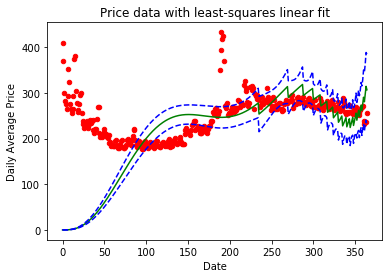

In [26]:
ax1 = airp_ave.plot.scatter(x='datedif',y='price',c='Red',title="Price data with least-squares linear fit")
ax1.set_xlabel("Date")
ax1.set_ylabel("Daily Average Price")

ax1.plot(predict_df['datedif'], prediction_output['mean'],color="green")
ax1.plot(predict_df['datedif'], prediction_output['mean_ci_lower'], color="blue",linestyle="dashed")
ax1.plot(predict_df['datedif'], prediction_output['mean_ci_upper'], color="blue",linestyle="dashed");

In [27]:
r2_train = r2_score(airp_ave['price'], prediction_output['mean'])
r2_test = r2_score(airp_ave_test['price'], fit_lm.get_prediction(predict_df_test).summary_frame()['mean'])
print('training r2 score:',r2_train,', test r2 score:', r2_test)

training r2 score: -3.973536531326528 , test r2 score: -3.6775242312221215


From the figure above, we can see that the fitting is very poor, and the problem may not just due to overfitting. Generally, using high-order polynomial fitting will  makes the coefficients very sensitive to small variations in the data and/or roundoff in the computations, which is also known as Runge's phenomenon. The large oscillation at both ends of the fitting curve, which almost touchs zero at the left end and increases a lot at the right end, may be caused by such problem. One way to address this problem might be add a regularization term for the coefficients, which can limit the sensitivity of those large coefficients.

### 3. Smoothing spline model with the smoothness parameter chosen by cross-validation on the training set.

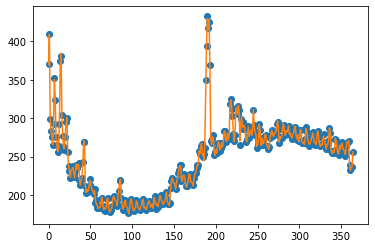

In [28]:
N = 300
gam = LinearGAM(s(0,lam=0, n_splines=N)).fit(airp_ave['datedif'],airp_ave['price'])

x2 = airp_ave['datedif']
plt.plot(airp_ave['datedif'], airp_ave['price'], 'o', x2, gam.predict(x2))
plt.show()

In [29]:
def cross_val_score(X, y, cv, lam):
    kf = KFold(n_splits=cv)
    kf.get_n_splits(X)
    score = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        gam = LinearGAM(s(0,lam=lam, n_splines=N)). fit(X_train, y_train)
        score.append(r2_score(y_test, gam.predict(X_test)))
    return np.mean(score)
# print(cross_val_score(airp_ave['datedif'], airp_ave['price'], 10, 25000))

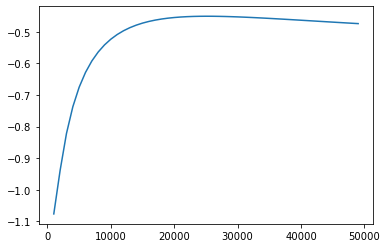

In [30]:
scores = []
lamd = np.arange(1e3,5e4,1e3)
for lam in lamd:
    scores.append(cross_val_score(airp_ave['datedif'], airp_ave['price'], 10, lam))

plt.plot(lamd, scores)
plt.show()

In [31]:
lamd[np.argmax(scores)]

25000.0

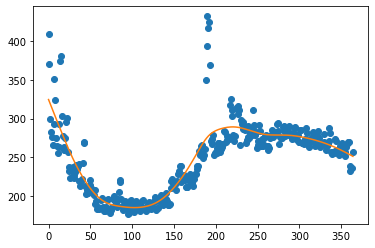

In [32]:
gam = LinearGAM(s(0,lam=25000, n_splines=N)). fit(airp_ave['datedif'], airp_ave['price'])
plt.plot(airp_ave['datedif'], airp_ave['price'], 'o', airp_ave['datedif'], gam.predict(airp_ave['datedif']))
plt.show()

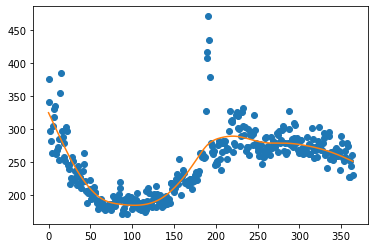

In [33]:
plt.plot(airp_ave_test['datedif'], airp_ave_test['price'], 'o', airp_ave_test['datedif'], gam.predict(airp_ave_test['datedif']))
plt.show()

In [34]:
r2_score(airp_ave_test['price'], gam.predict(airp_ave_test['datedif']))

0.7244174118148285

By cross validation, I found the optimal lambda to be 25000 for smoothing.

A case with more smoothing:

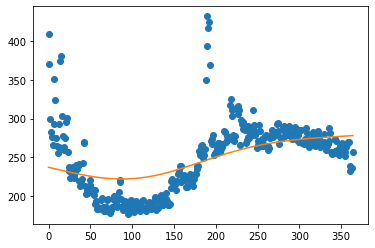

In [35]:
gam = LinearGAM(s(0,lam=1e7, n_splines=N)). fit(airp_ave['datedif'], airp_ave['price'])
plt.plot(airp_ave['datedif'], airp_ave['price'], 'o', airp_ave['datedif'], gam.predict(airp_ave['datedif']))
plt.show()

A case with less smoothing:

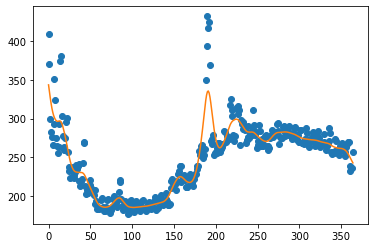

In [36]:
gam = LinearGAM(s(0,lam=100, n_splines=N)). fit(airp_ave['datedif'], airp_ave['price'])
plt.plot(airp_ave['datedif'], airp_ave['price'], 'o', airp_ave['datedif'], gam.predict(airp_ave['datedif']))
plt.show()

### 4. Effects of parameters

By comparing the R2 score of all the models, the smoothing spline model performs the best, which gives 0.724 as the R2 score on the test data set. The parameters are importance in determining the prediction results. As for the linear model, higher degree gives higher R2 score, however, it risks overfitting when the order of degree gets too high. As for the smoothing spline model, the smoothing paramter solved this problem. By using cross validation, we can find the optimal smoothing parameter, so that we can avoid overfitting while gainning the highest R2 score.

### Part 1b: Adapting to weekends

It is possible/likely that prices on weekends (Friday nights and Saturday nights) are systematically higher than prices on weekdays, and that including this aspect of the data-generating process in our model will produce a better fit.

5. Create a binary indicator of weekend versus non-weekend, and include it in your best-performing model from above. How does it impact the model's performance?  
*Hint*: include a categorical variable in a GAM by importing and using `pygam.f` in the same way you've used `pygam.s` for continuous variables.


In [37]:
airp_test['month'] = airp_test['date'].dt.month
airp_test['day'] = airp_test['date'].dt.dayofweek
airp_test.head()

,index,listing_id,date,available,price,datedif,month,day
0,0,21205442,2018-09-28,t,138.0,357,9,4
1,1,5166870,2018-08-11,t,210.0,309,8,5
2,12,19455818,2018-04-13,t,869.0,189,4,4
3,14,20351854,2017-12-23,t,239.0,78,12,5
4,17,20622324,2018-02-09,t,259.0,126,2,4


In [38]:
from datetime import timedelta
airp['is_weekend'] = (abs(airp['day'] -4.5) <1)
airp_test['is_weekend'] = (abs(airp['day'] -4.5) <1)

min_date = min(airp['date'].min(), airp_test['date'].min())
airp['datedif'] = (airp['date'] - min_date).dt.days
airp_test['datedif'] = (airp_test['date'] - min_date).dt.days

airp_ave = airp.groupby(['datedif', 'date']).mean()[['price','is_weekend']].reset_index()
airp_ave_test = airp_test.groupby(['datedif']).mean()[['price','is_weekend']].reset_index()

In [39]:
airp_ave.head()

,datedif,date,price,is_weekend
0,0,2017-10-06,370.173410,True
1,1,2017-10-07,409.298701,True
2,2,2017-10-08,299.128713,False
3,3,2017-10-09,282.768908,False
4,4,2017-10-10,275.933202,False


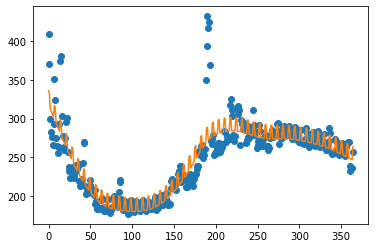

In [40]:
gam = LinearGAM(s(0,lam=25000, n_splines=N) + f(1)). fit(airp_ave[['datedif', 'is_weekend']], airp_ave['price'])
plt.plot(airp_ave['datedif'], airp_ave['price'], 'o', airp_ave['datedif'], gam.predict(airp_ave[['datedif', 'is_weekend']]))
plt.show()

In [41]:
r2_score(airp_ave_test['price'], gam.predict(airp_ave_test[['datedif', 'is_weekend']]))

0.7085671730777368

The performance didn't get improved by comparing the R2 score with the originial model. From the figure above, we can see that the the small wiggles (price increases) during the weekends, which reflects the effect of adding the new feature "is_weekend" into the model.

### Part 1c: Going the Distance

You may have noticed from your scatterplots of average price versus day on the training set that there are a few days with abnormally high average prices.

Sort the training data in decreasing order of average price, extracting the 10 most expensive dates. Why are the prices on these days so high? Is it something about the days themselves, noise, an artifact of data collection, or something else?

In [42]:
top10 = airp_ave.sort_values(by='price', ascending=False).head(10)
top10.head(10)

,datedif,date,price,is_weekend
190,190,2018-04-14,432.680761,True
192,192,2018-04-16,425.289528,False
191,191,2018-04-15,417.170404,False
1,1,2017-10-07,409.298701,True
189,189,2018-04-13,393.609047,True
15,15,2017-10-21,381.526515,True
14,14,2017-10-20,374.955932,True
0,0,2017-10-06,370.173410,True
193,193,2018-04-17,369.371060,False
7,7,2017-10-13,351.800725,True


In [43]:
joined = airp.set_index('date').join(top10.set_index('date'),lsuffix='_ori', rsuffix='_top').sort_values(by='price_ori', ascending=False)

In [44]:
sum(joined['price_ori']>2000)

49

There are no holidays around those dates, so such high prices may not be caused by holiday reason. After checking the single prices on those dates, I found that there are 49 prices listed higher than $3000, which might be artifacts of data collection.

### Problem 2: Predicting Airbnb Rental Price Through Listing Features

In this problem, we'll continue our exploration of Airbnb data by predicting price based on listing features. The data can be found in `listings_train.csv` and `listings_test.csv`.

First, visualize the relationship between each of the predictors and the response variable. Does it appear that some of the predictors have a nonlinear relationship with the response variable?

In [45]:
airl = pd.read_csv("./data/listings_train.csv")
airl.head(10)

,host_total_listings_count,room_type,latitude,longitude,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,availability_365,number_of_reviews
0,1,Private room,42.347956,-71.155196,1.0,1,1,52,1,65,365,26
1,85,Entire home/apt,42.349299,-71.083470,1.0,0,1,110,1,104,107,38
2,6,Entire home/apt,42.341902,-71.073792,1.0,1,1,67,45,56,322,9
3,1,Entire home/apt,42.319235,-71.105016,2.0,2,2,103,8,113,341,49
4,1,Entire home/apt,42.346452,-71.134896,1.0,0,1,8,24,82,41,13
5,1,Entire home/apt,42.342533,-71.053857,1.5,1,1,83,2,67,9,2
6,12,Entire home/apt,42.348644,-71.061820,1.0,2,4,87,8,101,144,16
7,12,Private room,42.297805,-71.058928,1.5,1,1,319,8,1,346,86
8,630,Entire home/apt,42.339723,-71.048382,1.0,1,1,36,45,112,85,3
9,364,Entire home/apt,42.351563,-71.062661,2.0,2,2,336,1,4,362,2


In [46]:
airl_test = pd.read_csv("./data/listings_test.csv")

In [47]:
dic = {'Entire home/apt':0,'Private room':1, 'Shared room':2}
airl['room_type'] = airl['room_type'].map(dic)
airl_test['room_type'] = airl_test['room_type'].map(dic)

In [48]:
airl.dtypes

host_total_listings_count      int64
room_type                      int64
latitude                     float64
longitude                    float64
bathrooms                    float64
bedrooms                       int64
beds                           int64
price                          int64
security_deposit               int64
cleaning_fee                   int64
availability_365               int64
number_of_reviews              int64
dtype: object

In [49]:
for column in airl.columns:
    uniques = sorted(airl[column].unique())
    empty = len(airl[airl[column] == '']) 
    print('{0:25s} {1:5d} {2:5d}\t'.format(column, len(uniques), empty) , uniques[:5])

host_total_listings_count    43     0	 [1, 2, 3, 4, 5]
room_type                     3     0	 [0, 1, 2]
latitude                   4370     0	 [42.2357603518114, 42.235941807706794, 42.235968547261294, 42.2361518217365, 42.2367925708106]
longitude                  4370     0	 [-71.1792573829018, -71.17591760107791, -71.1738077869403, -71.173374972519, -71.1732073138089]
bathrooms                    12     0	 [0.0, 0.5, 1.0, 1.5, 2.0]
bedrooms                      9     0	 [0, 1, 2, 3, 4]
beds                         15     0	 [0, 1, 2, 3, 4]
price                       357     0	 [1, 2, 3, 4, 5]
security_deposit             59     0	 [1, 2, 3, 4, 5]
cleaning_fee                116     0	 [1, 2, 3, 4, 5]
availability_365            358     0	 [0, 1, 2, 3, 4]
number_of_reviews           228     0	 [0, 1, 2, 3, 4]


/anaconda3/envs/cs109b/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:252: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


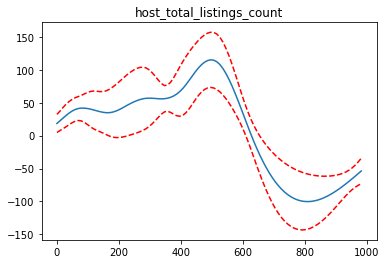

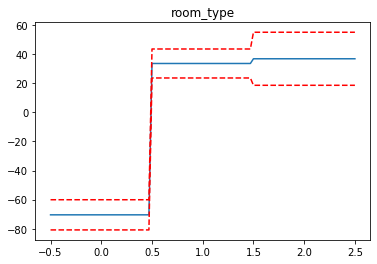

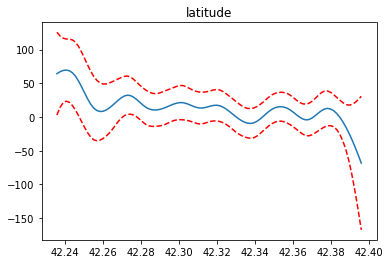

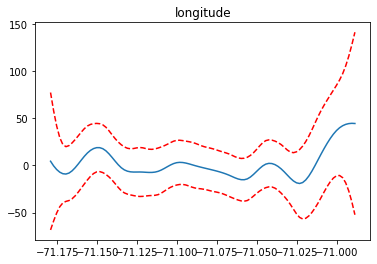

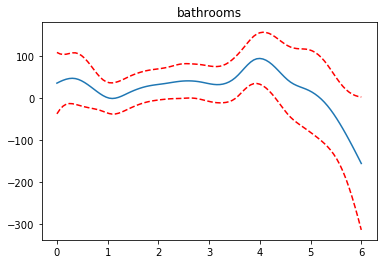

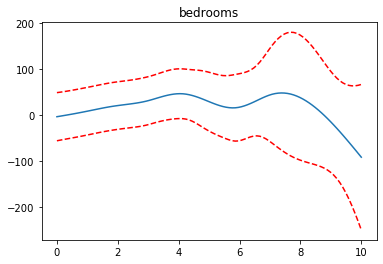

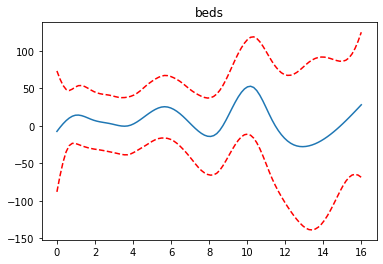

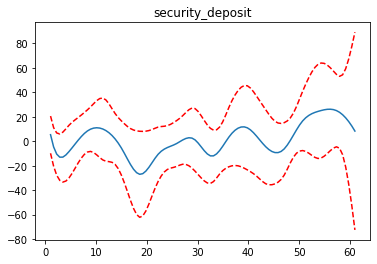

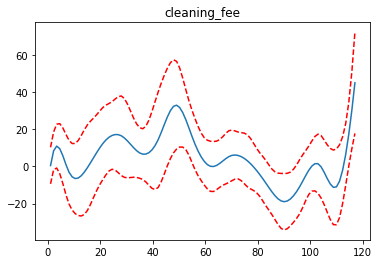

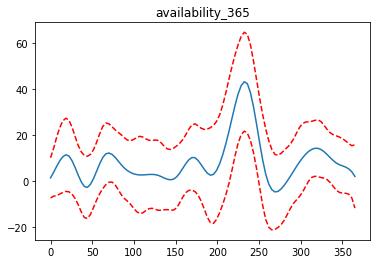

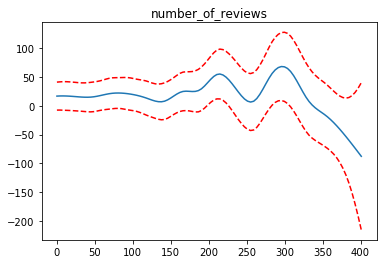

In [50]:
from pygam import LinearGAM, s, f

X = airl[['host_total_listings_count', 'room_type', 'latitude', 'longitude',
       'bathrooms', 'bedrooms', 'beds', 'security_deposit',
       'cleaning_fee', 'availability_365', 'number_of_reviews']]
y = airl['price']

## model
gam = LinearGAM(s(0) + f(1) + s(2) + s(3)+ s(4)+ s(5)+ s(6)+ s(7)+ s(8)+ s(9)+ s(10))
gam.fit(X, y)

titles = ['host_total_listings_count', 'room_type', 'latitude', 'longitude',
       'bathrooms', 'bedrooms', 'beds', 'security_deposit',
       'cleaning_fee', 'availability_365', 'number_of_reviews']
for i in range(11):
    XX = gam.generate_X_grid(term=i)
    plt.figure()
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
#     ax.set_ylim(-30,30)
    plt.title(titles[i])

Based on the figures above, it appears that some predictors have a mnonlinear relationship with the response variable, such as latitude, longitude, security deposit, cleaning fee, and availability_365.

### Part 2a: Polynomial Regression

Fit the following models on the training set and compare the $R^2$ score of the fitted models on the test set:
    
* Linear regression
* Regression with polynomial basis functions of degree 3 (i.e., basis functions $x$, $x^2$, $x^3$ for each predictor $x$) for quantitative predictors.

#### 1. Linear Regression

In [51]:
predict_df = airl.iloc[:,[0,1,2,3,4,5,6,8,9,10,11]]
predict_df_test = airl_test.iloc[:,[0,1,2,3,4,5,6,8,9,10,11]]

In [52]:
fit_lm = sm.ols(formula="price ~ C(room_type)+host_total_listings_count+latitude+longitude+bathrooms+bedrooms+beds+security_deposit+cleaning_fee+availability_365+number_of_reviews",data=airl).fit()
prediction_output = fit_lm.get_prediction(predict_df).summary_frame()
prediction_output.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,245.399976,5.395829,234.821407,255.978545,49.574961,441.224991
1,101.407501,4.390421,92.800042,110.014960,-94.320930,297.135932
2,126.954208,4.725535,117.689757,136.218660,-68.804216,322.712632
3,162.902017,5.219100,152.669928,173.134107,-32.904587,358.708621
4,112.011830,4.989973,102.228945,121.794715,-83.771814,307.795474


In [53]:
airl = airl.reset_index()
airl_test = airl_test.reset_index()

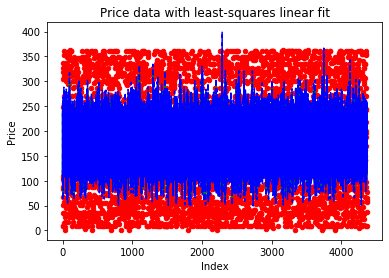

In [54]:
ax1 = airl.plot.scatter(x='index',y='price',c='Red',title="Price data with least-squares linear fit")
ax1.set_xlabel("Index")
ax1.set_ylabel("Price")

ax1.plot(predict_df.index, prediction_output['mean'],color="green")
ax1.plot(predict_df.index, prediction_output['mean_ci_lower'], color="blue",linestyle="dashed")
ax1.plot(predict_df.index, prediction_output['mean_ci_upper'], color="blue",linestyle="dashed");

In [55]:
r2_train = r2_score(airl['price'], prediction_output['mean'])
r2_test = r2_score(airl_test['price'], fit_lm.get_prediction(predict_df_test).summary_frame()['mean'])
print('r2 score on training set:',r2_train, '  r2 score on test set:',r2_test)

r2 score on training set: 0.24941504849625218   r2 score on test set: 0.18479127231125647


#### 2. Regression with polynomial basis functions of degree 3

In [56]:
fit_lm = sm.ols(formula="price ~ C(room_type)+host_total_listings_count+np.power(host_total_listings_count,2)+\
                np.power(host_total_listings_count,3)+latitude+np.power(latitude,2)+np.power(latitude,3)\
                +longitude+np.power(longitude,2)+np.power(longitude,3)\
                +bathrooms+np.power(bathrooms,2)+np.power(bathrooms,3)\
                +bedrooms+np.power(bedrooms,2)+np.power(bedrooms,3)\
                +beds+np.power(beds,2)+np.power(beds,3)\
                +security_deposit+np.power(security_deposit,2)+np.power(security_deposit,3)\
                +cleaning_fee+np.power(cleaning_fee,2)+np.power(cleaning_fee,3)\
                +availability_365+np.power(availability_365,2)+np.power(availability_365,3)\
                +number_of_reviews+np.power(number_of_reviews,2)+np.power(number_of_reviews,3)\
                ",data=airl).fit()
prediction_output = fit_lm.get_prediction(predict_df).summary_frame()
prediction_output.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,240.370716,7.529539,225.608972,255.132460,46.654315,434.087117
1,124.395028,7.908115,108.891082,139.898974,-69.379344,318.169400
2,122.963675,6.275277,110.660925,135.266424,-70.580875,316.508224
3,167.792159,9.274993,149.608434,185.975884,-26.215013,361.799331
4,96.306329,6.876234,82.825397,109.787261,-97.316682,289.929340


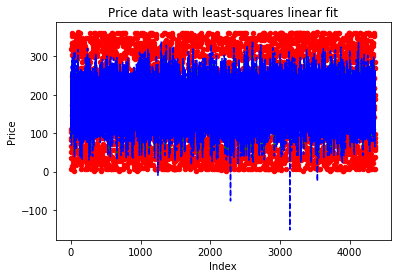

In [57]:
ax1 = airl.plot.scatter(x='index',y='price',c='Red',title="Price data with least-squares linear fit")
ax1.set_xlabel("Index")
ax1.set_ylabel("Price")

ax1.plot(predict_df.index, prediction_output['mean'],color="green")
ax1.plot(predict_df.index, prediction_output['mean_ci_lower'], color="blue",linestyle="dashed")
ax1.plot(predict_df.index, prediction_output['mean_ci_upper'], color="blue",linestyle="dashed");

In [58]:
r2_train = r2_score(airl['price'], prediction_output['mean'])
r2_test = r2_score(airl_test['price'], fit_lm.get_prediction(predict_df_test).summary_frame()['mean'])
print('r2 score on training set:',r2_train, '  r2 score on test set:',r2_test)

r2 score on training set: 0.2706476943831555   r2 score on test set: 0.2378323268773791


### Part 2b: Generalized Additive Model (GAM)

1. Do you see any advantage in fitting an additive regression model to these data, compared to the above models?

1. Fit a GAM to the training set, and compare the test $R^2$ of the fitted model to the above models. You may use a smoothing spline basis function on each predictor, with the same smoothing parameter for each basis function, tuned using cross-validation on the training set.

2. Plot and examine the smooth of each predictor for the fitted GAM. What are some useful insights conveyed by these plots?


#### 1

From observations in the beginning of problem2, some predictors have a mnonlinear relationship with the response variable. If use the above models, we should test many different degrees of polynomials for each feature and take the risk of overfitting, however, using additive regression model to the data will solve the problem and use smoothing parameter to avoid overfitting.

#### 2

In [59]:
predict_df.head()

,host_total_listings_count,room_type,latitude,longitude,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,availability_365,number_of_reviews
0,1,1,42.347956,-71.155196,1.0,1,1,1,65,365,26
1,85,0,42.349299,-71.083470,1.0,0,1,1,104,107,38
2,6,0,42.341902,-71.073792,1.0,1,1,45,56,322,9
3,1,0,42.319235,-71.105016,2.0,2,2,8,113,341,49
4,1,0,42.346452,-71.134896,1.0,0,1,24,82,41,13


In [60]:
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder
#your code here

N = 50

def cross_val_score2(X, y, cv, lam):
    kf = KFold(n_splits=cv)
    kf.get_n_splits(X)
    score = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        gam = LinearGAM(s(0,lam=lam, n_splines=N) + f(1) + s(2,lam=lam, n_splines=N) + s(3,lam=lam, n_splines=N) + \
                        s(4,lam=lam, n_splines=N) + s(5,lam=lam, n_splines=N) + s(6,lam=lam, n_splines=N) + \
                        s(7,lam=lam, n_splines=N) + s(8,lam=lam, n_splines=N) + s(9,lam=lam, n_splines=N) + \
                        s(10,lam=lam, n_splines=N)).fit(X_train, y_train)
        score.append(r2_score(y_test, gam.predict(X_test)))
    return np.mean(score)

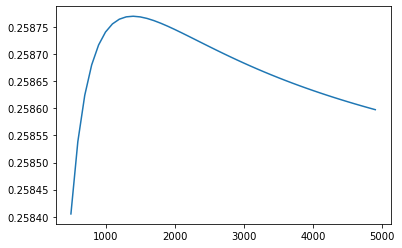

In [61]:
scores = []
lamd = np.arange(5e2,5e3,1e2)
for lam in lamd:
    scores.append(cross_val_score2(predict_df, airl['price'], 10, lam))

plt.plot(lamd, scores)
plt.show()

In [62]:
lamd[np.argmax(scores)]

1400.0

In [63]:
lam = 1400
gam = LinearGAM(s(0,lam=lam, n_splines=N) + f(1) + s(2,lam=lam, n_splines=N) + s(3,lam=lam, n_splines=N) + \
                        s(4,lam=lam, n_splines=N) + s(5,lam=lam, n_splines=N) + s(6,lam=lam, n_splines=N) + \
                        s(7,lam=lam, n_splines=N) + s(8,lam=lam, n_splines=N) + s(9,lam=lam, n_splines=N) + \
                        s(10,lam=lam, n_splines=N)).fit(predict_df, airl['price'])
print('r2 score on test data set:', r2_score(airl_test['price'], gam.predict(predict_df_test)))

r2 score on test data set: 0.2445383589614063


We can see that the r2 score is higher in the test data set than the method in Part 2a.

#### 3

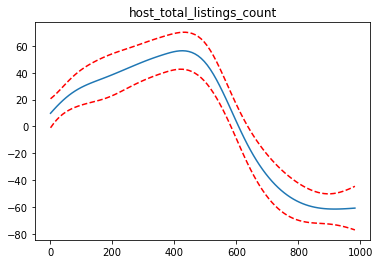

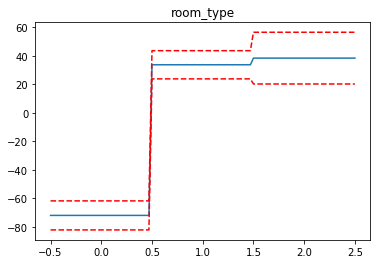

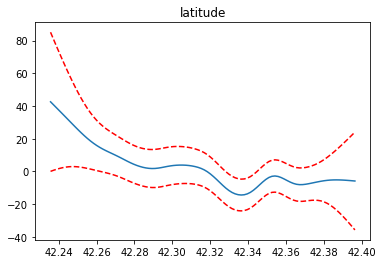

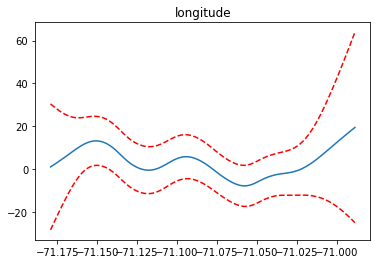

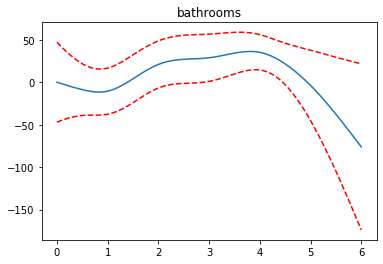

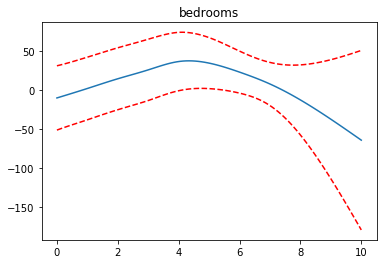

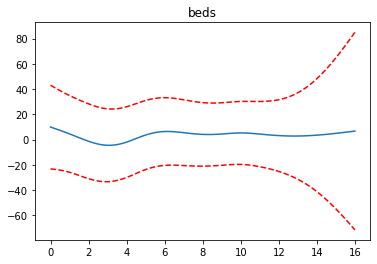

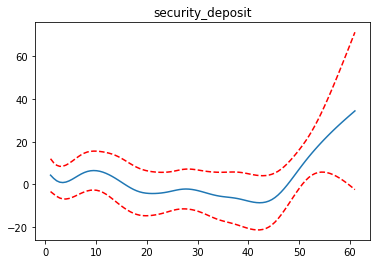

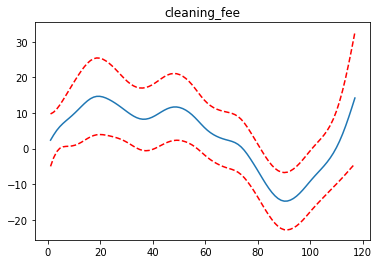

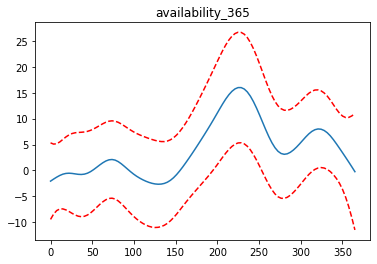

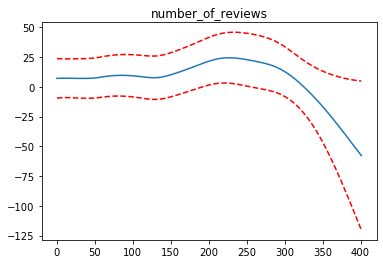

In [64]:
titles = ['host_total_listings_count', 'room_type', 'latitude', 'longitude',
       'bathrooms', 'bedrooms', 'beds', 'security_deposit',
       'cleaning_fee', 'availability_365', 'number_of_reviews']
for i in range(11):
    XX = gam.generate_X_grid(term=i)
    plt.figure()
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
#     ax.set_ylim(-30,30)
    plt.title(titles[i])

Some obervation from the figures:
1. After applying the smoothing parameter, the relationship becomes smoother than the previous relationship figures.

2. host_total_listing_count have a linear relationship with the price, and higher host_total_listing_count units have higher prices.

3. latitude has a negative relationship with the price, while longitude almost have no clear relationship with the prices.

4. More bathrooms, more bedrooms, and more beds means higher prices.

5. Security deposit and cleaning fee have no clear relationship with the prices.

6. Availability_365 has a nonlinear relationship with the prices, and higher availability tend to give higher price.

5. Number_of_reviews also reflect the prices, and higher number of reviews tend to have higher prices.

### Part 2c: Putting it All Together
Using the GAM outputs and insights from part 1), discuss the most important variables in the driving prices, and give advide to a frugal traveller hoping to visit Boston.

Adding up all the information from the analysis in part 1 and part 2, we can see that the date is still the most important factor to determine the prices while other factors like number of bedrooms and location(especially latitude) will also influence the prices. In summary, the advice I would give are trying to visit Boston during the winter time and on weekdays. In terms of choosing location, I would recommand choosing a unit where the latitude is higher, and the number of rooms are smaller, which tends to have a lower price.